**done remotely on greenplanet**

In [1]:
import numpy
import gdal
import osr
import glob
import xarray
import re
import pprint

import cartopy
import cmocean
import matplotlib
import matplotlib.pyplot as mp

import matplotlib.cm as mcm

list the files in the directory

get 2002 data

In [194]:
file_list_all = sorted(glob.glob('/beegfs/DATA/pritchard/blangenb/MODIS_ARCHIVE/MCD12Q1.006/*2002001*.hdf'))
reg_exp = re.compile('.*h(27|28|29|30|31|32)v(08|09|10)(.*\.hdf)$')
file_list = [filename for filename in file_list_all if re.match(reg_exp, filename)]
gdal_datasets = [gdal.Open(f) for f in file_list]
gdal_lc_type1 = [ds.GetSubDatasets()[0][0] for ds in gdal_datasets]

In [195]:
lc_mosaic = gdal.BuildVRT('../vrt_files/gdal_lc_day_mosaic.vrt', gdal_lc_type1)
lc_mosaic_data = numpy.array(lc_mosaic.ReadAsArray(), dtype=numpy.float)
lc_mosaic_data_2002 = numpy.copy(lc_mosaic_data)

get 2016 data

In [196]:
file_list_all = sorted(glob.glob('/beegfs/DATA/pritchard/blangenb/MODIS_ARCHIVE/MCD12Q1.006/*2016001*.hdf'))
reg_exp = re.compile('.*h(27|28|29|30|31|32)v(08|09|10)(.*\.hdf)$')
file_list = [filename for filename in file_list_all if re.match(reg_exp, filename)]
gdal_datasets = [gdal.Open(f) for f in file_list]
gdal_lc_type1 = [ds.GetSubDatasets()[0][0] for ds in gdal_datasets]

In [5]:
lc_mosaic = gdal.BuildVRT('../vrt_files/gdal_lc_day_mosaic.vrt', gdal_lc_type1)
lc_mosaic_data = numpy.array(lc_mosaic.ReadAsArray(), dtype=numpy.float)
lc_mosaic_data_2016 = numpy.copy(lc_mosaic_data)

get the geotransform info from one of these data sets

In [6]:
lc_geotrans = lc_mosaic.GetGeoTransform()

use the geotransform info to create a data_extent tuple for cartopy

In [9]:
data_extent = (lc_geotrans[0], \
               lc_geotrans[0] + lc_mosaic.RasterXSize*lc_geotrans[1], \
               lc_geotrans[3] + lc_mosaic.RasterYSize*lc_geotrans[5], \
               lc_geotrans[3])

prepare colormaps

In [42]:
modis_type_dict = {}
modis_type_dict['1'] = 'Evergreen needleleaf forest'
modis_type_dict['2'] = 'Evergreen broadleaf forest'
modis_type_dict['3'] = 'Deciduous needleleaf forest'
modis_type_dict['4'] = 'Deciduous broadleaf forest'
modis_type_dict['5'] = 'Mixed forest'
modis_type_dict['6'] = 'Closed shrublands'
modis_type_dict['7'] = 'Open shrublands'
modis_type_dict['8'] = 'Woody savannas'
modis_type_dict['9'] = 'Savannas'
modis_type_dict['10'] = 'Grasslands'
modis_type_dict['11'] = 'Permanent wetlands'
modis_type_dict['12'] = 'Croplands'
modis_type_dict['13'] = 'Urban and built-up'
modis_type_dict['14'] = 'Cropland/natural veg. mosaic'
modis_type_dict['15'] = 'Snow and ice'
modis_type_dict['16'] = 'Barren or sparsely vegetated'
modis_type_dict['17'] = 'Water'
#modis_type_dict['255'] = 'Fill Value'

In [43]:
type_numbers = numpy.arange(1,18,dtype=numpy.int)
type_name = [modis_type_dict[str(i)] for i in type_numbers]

In [79]:
type_numbers.min()

1

In [153]:
human_cmap = mcm.YlOrRd_r #Purples
water_cmap = mcm.Blues
veg_cmap = mcm.Greens_r
shrub_cmap = mcm.pink #YlOrBr

svals = numpy.linspace(0.2,0.85,5)
vvals = numpy.linspace(0.2,0.85,5)
hvals = [0.25,0.5,0.75]

colors_list = [veg_cmap(vvals[0]),veg_cmap(vvals[1]),veg_cmap(vvals[2]),veg_cmap(vvals[3]),veg_cmap(vvals[4]),\
               shrub_cmap(svals[0]),shrub_cmap(svals[1]),shrub_cmap(svals[2]),shrub_cmap(svals[3]),shrub_cmap(svals[4]),\
               water_cmap(0.5),\
               human_cmap(hvals[0]),human_cmap(hvals[1]),human_cmap(hvals[2]),\
               '0.7','0.9',water_cmap(0.75)]

categorical_cmap = matplotlib.colors.ListedColormap(colors_list, name='None')

norm = matplotlib.colors.BoundaryNorm(numpy.arange(type_numbers.min()-0.5,type_numbers.max()+0.5+1,1),\
                                                   categorical_cmap.N)

practice plot

In [176]:
plot_array = numpy.random.randint(low=1, high=17, size=(10,10))
#plot_array = numpy.ones((10,10))*16

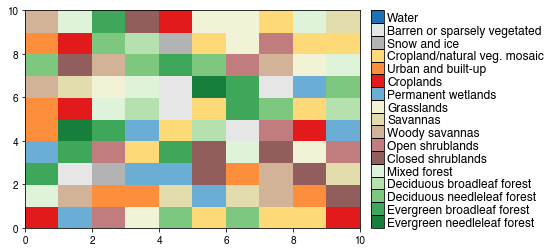

In [177]:
fontsize=12

fig = mp.figure()

ax = fig.add_subplot(111)

landuse_map = ax.pcolormesh(plot_array, cmap=categorical_cmap, norm=norm, vmin=1, vmax=17)

ax_pos = ax.get_position()
cbar_ax = fig.add_axes([ax_pos.x1+0.025,ax_pos.y0,0.03,ax_pos.height])
cbar = fig.colorbar(landuse_map, cax=cbar_ax, drawedges=True)
cbar.dividers.set_color('0')
cbar.dividers.set_linewidth(1)
cbar.set_ticks(type_numbers)
cbar.set_ticklabels(type_name)
cbar.ax.tick_params(labelsize=fontsize, length=0)

plot on original projection

In [197]:
field = lc_mosaic_data_2002
field[field==255] = numpy.nan
#field[field==17] = numpy.nan

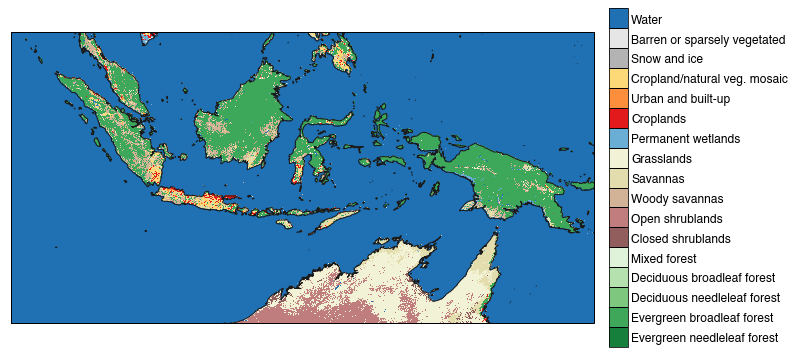

In [198]:
modis_globe = cartopy.crs.Globe(datum='WGS84', ellipse='sphere', semimajor_axis=6371007.181)
map_proj = cartopy.crs.Sinusoidal(central_longitude=0, false_northing=0, false_easting=0, globe=modis_globe)
data_proj = cartopy.crs.Sinusoidal(central_longitude=0, false_northing=0, false_easting=0, globe=modis_globe)
geodetic_proj = cartopy.crs.Geodetic()

fig = mp.figure(figsize=(8.5,5))
ax = fig.add_subplot(111, projection=map_proj)
image = ax.imshow(field, \
                  extent=data_extent, \
                  origin='upper', transform=data_proj, \
                  vmin=1,vmax=17,norm=norm,\
                  cmap=categorical_cmap)
ax.coastlines(resolution='10m', color='0.1')

fig.tight_layout()

ax_pos = ax.get_position()
cbar_ax = fig.add_axes([ax_pos.x1+0.025,ax_pos.y0,0.03,ax_pos.height])
cbar = fig.colorbar(image, cax=cbar_ax, drawedges=True)
cbar.dividers.set_color('0')
cbar.dividers.set_linewidth(1)
cbar.set_ticks(type_numbers)
cbar.set_ticklabels(type_name)
cbar.ax.tick_params(labelsize=fontsize, length=0)

fig.savefig('/beegfs/DATA/pritchard/blangenb/analysis/_github_repos_research/modis-analysis/figures/modis_2002_landcover.png', dpi=600, bbox_inches='tight', transparent=True)

plot 2016

In [199]:
field = lc_mosaic_data_2016
field[field==255] = numpy.nan
#field[field==17] = numpy.nan

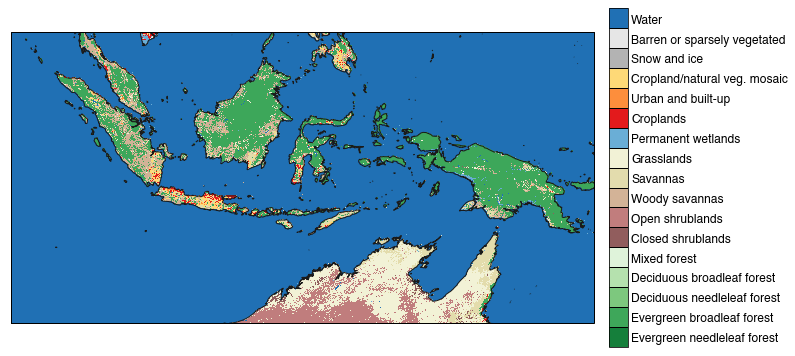

In [200]:
modis_globe = cartopy.crs.Globe(datum='WGS84', ellipse='sphere', semimajor_axis=6371007.181)
map_proj = cartopy.crs.Sinusoidal(central_longitude=0, false_northing=0, false_easting=0, globe=modis_globe)
data_proj = cartopy.crs.Sinusoidal(central_longitude=0, false_northing=0, false_easting=0, globe=modis_globe)
geodetic_proj = cartopy.crs.Geodetic()

fig = mp.figure(figsize=(8.5,5))
ax = fig.add_subplot(111, projection=map_proj)
image = ax.imshow(field, \
                  extent=data_extent, \
                  origin='upper', transform=data_proj, \
                  vmin=1,vmax=17,norm=norm,\
                  cmap=categorical_cmap)
ax.coastlines(resolution='10m', color='0.1')


fig.tight_layout()

ax_pos = ax.get_position()
cbar_ax = fig.add_axes([ax_pos.x1+0.025,ax_pos.y0,0.03,ax_pos.height])
cbar = fig.colorbar(image, cax=cbar_ax, drawedges=True)
cbar.dividers.set_color('0')
cbar.dividers.set_linewidth(1)
cbar.set_ticks(type_numbers)
cbar.set_ticklabels(type_name)
cbar.ax.tick_params(labelsize=fontsize, length=0)

fig.savefig('/beegfs/DATA/pritchard/blangenb/analysis/_github_repos_research/modis-analysis/figures/modis_2016_landcover.png', dpi=600, bbox_inches='tight', transparent=True)

calculate grid points that have turned FROM any of the foreset types fo any of the shrublands, croplands, or urban/built up types

In [202]:
lc_converted = numpy.zeros((lc_mosaic_data.shape))
for i in range(lc_converted.shape[0]):
    for j in range(lc_converted.shape[1]):
        if (lc_mosaic_data_2002[i,j] in [1,2,3,4,5]) and (lc_mosaic_data_2016[i,j] in [6,7,8,9,10,12,13,14,16]):
            lc_converted[i,j] = 1.0

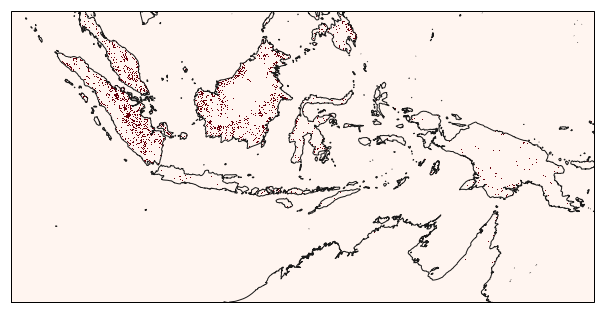

In [219]:
modis_globe = cartopy.crs.Globe(datum='WGS84', ellipse='sphere', semimajor_axis=6371007.181)
map_proj = cartopy.crs.Sinusoidal(central_longitude=0, false_northing=0, false_easting=0, globe=modis_globe)
data_proj = cartopy.crs.Sinusoidal(central_longitude=0, false_northing=0, false_easting=0, globe=modis_globe)
geodetic_proj = cartopy.crs.Geodetic()

fig = mp.figure(figsize=(8.5,5))
ax = fig.add_subplot(111, projection=map_proj)
image = ax.imshow(lc_converted, \
                  extent=data_extent, \
                  origin='upper', transform=data_proj, \
                  cmap='Reds')
ax.coastlines(resolution='10m', color='0.1')


fig.tight_layout()

# ax_pos = ax.get_position()
# cbar_ax = fig.add_axes([ax_pos.x1+0.025,ax_pos.y0,0.03,ax_pos.height])
# cbar = fig.colorbar(image, cax=cbar_ax, drawedges=True)
# cbar.dividers.set_color('0')
# cbar.dividers.set_linewidth(1)
# cbar.set_ticks(type_numbers)
# cbar.set_ticklabels(type_name)
# cbar.ax.tick_params(labelsize=fontsize, length=0)

fig.savefig('/beegfs/DATA/pritchard/blangenb/analysis/_github_repos_research/modis-analysis/figures/modis_2002_to_2016_converted.png', dpi=600, bbox_inches='tight', transparent=True)

plot on new projection (this time, plotting quality control data):